# Set the repository path

In [24]:
repo_path = r'D:\00PythonData\GITHUB\DANN_case_1'

# Import modules

In [25]:
import matplotlib.patches as mpatches
import os
import numpy as np
import sys
sys.path.append(repo_path)
import pyMRF
from pyMRF import get_init_labels_prob
from pyMRF import draw_labels_vect
from matplotlib import pyplot as plt

# Read the original stratigraphic profile dataset of the synthetic case

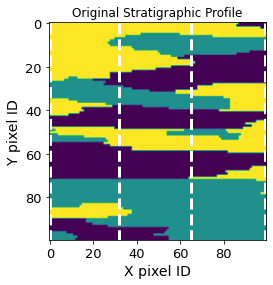

In [26]:

init_field_full = np.load(r'D:\00PythonData\GITHUB\DANN_case_1\case_dataset.npy') #2D
n_labels = len(np.unique(init_field_full))

init_field_bh = np.empty(init_field_full.shape)
init_field_bh[:] = np.nan
known_idx = np.array([0,32,65,99])# known borehole
init_field_bh[:,known_idx] = init_field_full[:,known_idx]

plt.figure()
plt.imshow(init_field_full)
legend_elements = [mpatches.Patch(facecolor='#411445', label='Label A'),
                   mpatches.Patch(facecolor='darkcyan', label='Label B'),
                   mpatches.Patch(facecolor='yellow', label='Label C')]
plt.tick_params(labelsize=13)
plt.xlabel('X pixel ID', fontsize=14)
plt.ylabel('Y pixel ID', fontsize=14)
plt.title('Original Stratigraphic Profile')
plt.vlines(known_idx, 0, 99.5, linewidth=3, colors = "w", linestyles = "dashed")
plt.show()

In [ ]:
# Initial field sampling and pre-test

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:51<00:00, 26.86it/s]


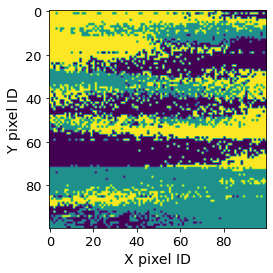

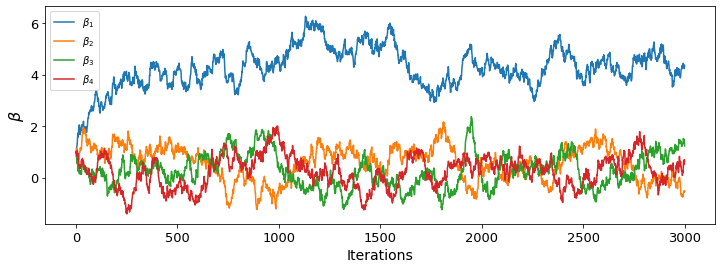

In [34]:
test_field = init_field_bh
coord_2d = np.array([[0,10],[0,10]])
my_mrf = pyMRF.Element(coord=coord_2d, init_field=test_field)
dist_KHMD, labels_prob_init = get_init_labels_prob(my_mrf)

my_mrf.fit(beta_prior_mean = [1,1,1,1], 
           beta_compl_accept = [False,False,False,False],
           fix_beta=False,
           beta_prior_cov=10,
           num_of_iter=3000, 
           beta_jump_length=0.01,
           dist_KHMD=dist_KHMD,
           labels_prob_init=labels_prob_init)

labels_bin = my_mrf.labels
init_image = labels_bin[0].reshape(my_mrf.phys_shp)
# plot initial field
plt.figure()
plt.imshow(init_image)
plt.xlabel('X pixel ID', fontsize=14)
plt.ylabel('Y pixel ID', fontsize=14)
plt.tick_params(labelsize=13)
plt.show()

# get posterior beta for batch simulation
beta_bin = np.array(my_mrf.betas)
beta_est = np.mean(beta_bin[1000:,:], axis=0)
beta_std = np.std(beta_bin[1000:,:], axis=0)
beta_cov = np.cov(beta_bin[1000:,:], rowvar=False)

# plot posterior beta
plt.figure(figsize=(12,4))
plt.plot(np.arange(beta_bin.shape[0]),beta_bin)
plt.xlabel('Iterations', fontsize=fontsize)
plt.ylabel(r'$\beta$', fontsize=fontsize+2)
plt.legend(labels=(r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\beta_4$'))
plt.tick_params(labelsize=labelsize)
plt.show()

 # Batch simulation

In [ ]:
test_field = init_field_bh
coord_2d = np.array([[0,10],[0,10]])
my_mrf = pyMRF.Element(coord=coord_2d, init_field=test_field)
dist_KHMD, labels_prob_init = get_init_labels_prob(my_mrf, epsilon=1, k=2, range_v=5, range_h=100)
for i in range(3):
    r = i+1
    n = "{:0>3d}".format(r)    
    my_mrf = pyMRF.Element(coord=coord_2d, init_field=test_field)    
    my_mrf.fit(beta_prior_mean = beta_est, 
               beta_compl_accept = [False,False,False,False],
               fix_beta=False,
               beta_prior_cov=beta_cov,
               num_of_iter=200, 
               beta_jump_length=0.01,
               dist_KHMD=dist_KHMD,
               labels_prob_init=labels_prob_init)  
    labels_bin = my_mrf.labels 
    ###### Save the configuration for the last 100 realizations of each simulation 
    #np.save(r'D:\00PythonData\GITHUB\DANN_case_1\batch_simulation\labels_set_%s.npy'%n, labels_bin[-100:])

# Analyze the configurations of the saved batch simulation

Text(0.5, 1.0, 'Robust Information Entropy')

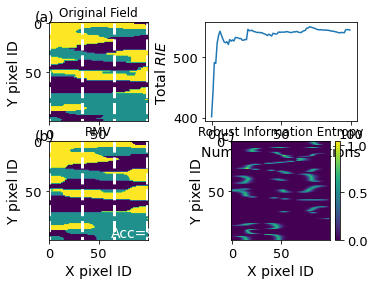

In [21]:
data_path = r'D:\00PythonData\GITHUB\DANN_case_1\batch_simulation'
os.chdir(data_path) 
data_list = os.listdir(data_path)


labels_set_bin = []
for i in range(len(data_list)):    
    labels_set_bin.append(np.load(data_list[i]))
labels_prob_in_chains = []
for i in range(len(labels_set_bin)):
    labels_set_i = labels_set_bin[i]
    comp_deck = np.einsum('ijk,i->ijk',np.array([np.ones_like(labels_set_i), ]*n_labels),
                                       np.arange(n_labels))
    labels_set_i_in_mask_deck = np.array([labels_set_i, ]*n_labels)
    diff = comp_deck - labels_set_i_in_mask_deck
    temp = np.zeros_like(diff, dtype=float)
    temp[(diff == 0)] = 1
    sum_flag = np.sum(temp, axis=1)
    labels_prob_i = sum_flag / 100
    labels_prob_in_chains.append(labels_prob_i)
labels_prob_in_chains = np.array(labels_prob_in_chains)
labels_prob_mean = np.mean(labels_prob_in_chains, axis=0)


##### get RMV with probability of each label
labels_prob_mean_t = labels_prob_mean.T
labels_idx = labels_prob_mean_t.argsort()[:,::-1] 
labels_f = labels_idx[:,0]
labels_field = labels_f.reshape(init_field_full.shape)
flag = labels_field.flatten() == init_field_full.flatten()
acc = sum(flag) / len(flag)

#### get info_enty
temp = np.copy(labels_prob_mean.T)
temp[np.where(temp == 0)] = 1
ie = np.sum(-temp * np.log(temp), axis=1)
info_entr = ie.reshape(init_field_full.shape)

#% total ie for 100 ites

total_ie_ite = []
for i in range(len(labels_prob_in_chains)):
    j = i+1
    labels_prob_in_chains_i = labels_prob_in_chains[0:j]
    labels_prob_mean_i = np.mean(labels_prob_in_chains_i, axis=0)
    temp_i = np.copy(labels_prob_mean_i.T)
    temp_i[np.where(temp_i == 0)] = 1
    ie_i = np.sum(-temp_i * np.log(temp_i), axis=1)
    total_ie_i = sum(ie_i)
    total_ie_ite.append(total_ie_i)
total_ie_ite = np.array(total_ie_ite)

#### get image

known_idx = np.array([0,33,66,99])


fig=plt.figure()

plt.subplot(2,2,1)
plt.imshow(init_field_full)

plt.vlines(known_idx, 0, 99.5, linewidth=3, colors = "w", linestyles = "dashed")
plt.tick_params(labelsize=13)
plt.xlabel('X pixel ID', fontsize=14)
plt.ylabel('Y pixel ID', fontsize=14)
plt.title('Original Field')
plt.text(-15, -2, '(a)', size = 14, color = "black")

plt.subplot(2,2,2)
plt.plot(np.arange(len(total_ie_ite)),total_ie_ite)
plt.xlabel('Number of simulations', fontsize=14)
plt.ylabel('Total ${RIE}$', fontsize=14)
plt.tick_params(labelsize=13)



plt.subplot(2,2,3)
sm=plt.imshow(labels_field)
plt.text(62, 97, "Acc=%s%%"% round(acc*100,3), size = 14, color = "w") 
plt.title('RMV')

plt.vlines(known_idx, 0, 99.5, linewidth=3, colors = "w", linestyles = "dashed")
plt.tick_params(labelsize=13)
plt.xlabel('X pixel ID', fontsize=14)
plt.ylabel('Y pixel ID', fontsize=14)
plt.text(-15, -2, '(b)', size = 14, color = "black")


ax=plt.subplot(2,2,4)
im=plt.imshow(info_entr.reshape(init_field_full.shape))
axins = ax.inset_axes([1.05, 0, 0.05, 1])
cb=fig.colorbar(im, cax=axins)
cb.ax.tick_params(labelsize=13)
plt.tick_params(labelsize=13)
plt.xlabel('X pixel ID', fontsize=14)
plt.ylabel('Y pixel ID', fontsize=14)
plt.text(-15, -2, '(c)', size = 14, color = "black")
plt.title('Robust Information Entropy')

